# Image Manipulations and Image Spaces

## Tutorial

In [535]:
import numpy as np
from PIL import Image

# Transform RGB array to Lab array
from skimage.color import rgb2lab, lab2rgb
# Transform RGB to HSV
from skimage.color import rgb2hsv, hsv2rgb

# Histogram equalization on the V channel
from skimage.exposure import equalize_hist

import os
from matplotlib import pyplot as plt
import ipyplot
import pandas as pd

# Part 1

## Utils

In [536]:
def image_to_array(image : Image) -> np.array:
    return np.array(image, dtype=float)

def array_to_image(arr : np.ndarray) -> Image:
    return Image.fromarray(arr.astype(np.uint8))

def concat_horizontal(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


In [537]:
sample_image = Image.open('dataset/1/4.1.01.tiff')
sample_array = image_to_array(sample_image)

## Metric Calculation Functions

### Compute Power

In [538]:
def compute_power(image_array):
    # Constants
    gamma = 0.7755
    w_0 = 1.48169521e-6
    w_R = 2.13636845e-7
    w_G = 1.77746706e-7
    w_B = 2.14348309e-7

    # Normalize pixel values to rang[0,1]
    image_array = image_array/255.0

    # Extract R,G,B channels
    R = image_array[:,:,0]
    G = image_array[:,:,1]
    B = image_array[:,:,2]

    # Compute pixel-wise power consumption
    P_pixel = w_R*(R**gamma) + w_G * (G ** gamma) + w_B * (B ** gamma)

    P_image = w_0 + np.sum(P_pixel)

    return P_image
#########################################
# Load the image
image_path = "4.1.06.tiff"  
image = Image.open(image_path)
image_array = np.array(image)

# Compute power consumption
power_consumption = compute_power(image_array)

# Display the result
print(f"Power consumption for the image: {power_consumption:.10f}")

Power consumption for the image: 0.0235280153


In [539]:
def compute_power_saved(original, distorted, func = compute_power):
    o = func(original)
    d = func(distorted)

    return (o-d)/o

#############################################
# Compute distortion between original and darker image
distortion_darker = compute_power_saved(image_array, image_array_v1)
print(f"Distortion (original vs. darker): {distortion_darker*100:.2f}%")

# Compute distortion between original and red-only image
distortion_red_only = compute_power_saved(image_array, image_array_v2)
print(f"Distortion (original vs. red-only): {distortion_red_only*100:.2f}%")

Distortion (original vs. darker): 32.98%
Distortion (original vs. red-only): 64.83%


### Compute Distortion

In [540]:
def compute_distortion(original_image, transformed_image):
    # Convert both images to L*a*b* space
    lab_original = rgb2lab(original_image)
    lab_transformed = rgb2lab(transformed_image)
    
    # Compute the Euclidean distance for each pixel
    pixel_distances = np.sqrt(
        (lab_original[:, :, 0] - lab_transformed[:, :, 0]) ** 2 +
        (lab_original[:, :, 1] - lab_transformed[:, :, 1]) ** 2 +
        (lab_original[:, :, 2] - lab_transformed[:, :, 2]) ** 2
    )
    
    # Sum all pixel distances to calculate total distortion
    epsilon = np.sum(pixel_distances)
    
    return epsilon

#############################################
# Compute distortion between original and darker image
distortion_darker = compute_distortion(image_array, image_array_v1)
print(f"Distortion (original vs. darker): {distortion_darker:.2f}")

# Compute distortion between original and red-only image
distortion_red_only = compute_distortion(image_array, image_array_v2)
print(f"Distortion (original vs. red-only): {distortion_red_only:.2f}")

Distortion (original vs. darker): 1493273.27
Distortion (original vs. red-only): 4534181.70


In [541]:
# Function to compute percentage distortion
def compute_percentage_distortion(image, distorted):
    
    distortion = compute_distortion(image/255, distorted/255)
    
    # Extract image dimensions
    height, width, _ = image.shape
    
    # Maximum possible Euclidean distance in Lab space
    L_max = 100.0
    a_max = 255.0
    b_max = 255.0
    max_distance_per_pixel = np.sqrt(L_max**2 + a_max**2 + b_max**2)
    
    # Total maximum possible distortion
    max_possible_distortion = max_distance_per_pixel * height * width
    
    # Calculate percentage distortion
    percentage_distortion = (distortion / max_possible_distortion)
    
    return percentage_distortion


# Compute distortion between original and darker image
distortion_darker = compute_percentage_distortion(image_array, image_array_v1)
print(f"Distortion (original vs. darker): {distortion_darker*100:.2f} %")

# Compute distortion between original and red-only image
distortion_red_only = compute_percentage_distortion(image_array, image_array_v2)
print(f"Distortion (original vs. red-only): {distortion_red_only*100:.2f} %")


Distortion (original vs. darker): 6.09 %


Distortion (original vs. red-only): 18.49 %


## Transformations

In [542]:
transformations = {}

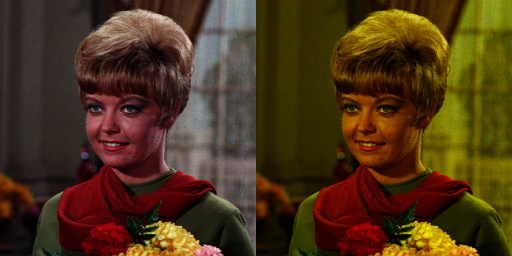

In [543]:
def hungry_blue(arr_in : np.ndarray, reduction : float) -> np.ndarray:
    arr = arr_in.copy()
    arr[:,:,2] = np.clip(arr[:,:,2] - 255*reduction, a_min = 0, a_max = np.inf)
    return arr

transformations['hungry_blue'] = (hungry_blue, [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], compute_power)

hungry_blue_array = hungry_blue(sample_array, .5)
concat_horizontal(sample_image, array_to_image(hungry_blue_array))

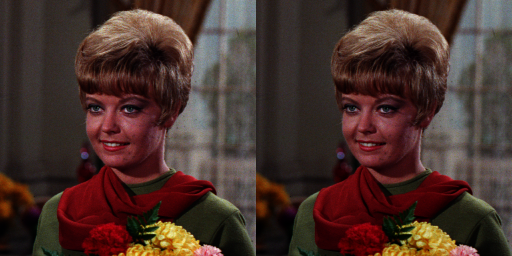

In [544]:
def dimming(arr_in : np.ndarray, reduction : float) -> np.ndarray:
    arr = arr_in.copy()
    arr = arr*reduction
    return arr

transformations['dimming'] = (dimming, [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], compute_power)

dimmed_array = dimming(sample_array, .9)
concat_horizontal(sample_image, array_to_image(dimmed_array))

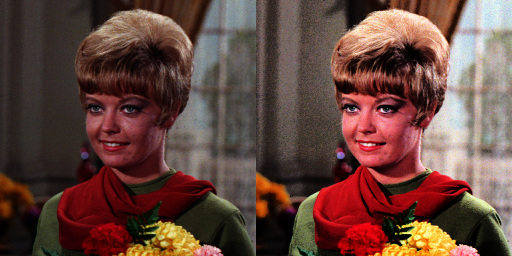

In [545]:
def hist_eq(arr_in : np.ndarray):
    image_array_hsv = rgb2hsv(arr_in/255)
    image_array_hsv[:, :, 2] = equalize_hist(image_array_hsv[:, :, 2])

    return hsv2rgb(image_array_hsv)*255

transformations['hist_equalization'] = (hist_eq, None, compute_power)

eq_array = hist_eq(sample_array)
concat_horizontal(sample_image, array_to_image(eq_array))

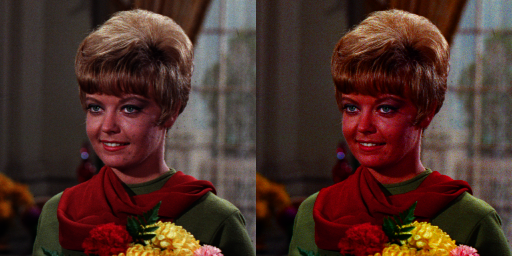

In [546]:
def dimm_saturation(arr_in : np.ndarray, increase):
    image_array_hsv = rgb2hsv(arr_in/255)
    image_array_hsv[:, :, 1] = np.clip(image_array_hsv[:, :, 1] * increase, a_min=0, a_max = 1)

    return hsv2rgb(image_array_hsv)*255

transformations['dimm_saturation'] = (dimm_saturation, [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2], compute_power)

dimm_saturation_array = dimm_saturation(sample_array, 1.5)
concat_horizontal(sample_image, array_to_image(dimm_saturation_array))

## DVS

In [547]:
P1 = 4.251e-5  
P2 = -3.029e-4 
P3 = 3.024e-5  
DEFAULT_VDD = 15  

def compute_pixel_current(drgb: np.ndarray, vdd: float = DEFAULT_VDD) -> np.ndarray:
    return (P1 * vdd * drgb) / 255 + (P2 * drgb) / 255 + P3
    

In [548]:
def compute_panel_power(i_cell: np.ndarray, vdd: float = DEFAULT_VDD) -> float:
    return vdd * np.sum(i_cell)


In [549]:
from typing import Tuple

def displayed_image(
        i_cell: np.ndarray,
        vdd: float,
        p1: float = 4.251e-5,
        p2: float = -3.029e-4,
        p3: float = 3.024e-5,
        orig_vdd: float = 15,
        ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Display an image on the OLED display taking into account the effect of DVS.

    :param i_cell: An array of the currents drawn by each pixel of the display.
    :param vdd: The new voltage of the display.
    """
    i_cell_max = (p1 * vdd * 1) + (p2 * 1) + p3
    image_rgb_max = (i_cell_max - p3) / (p1 * orig_vdd + p2) * 255
    out = np.round((i_cell - p3) / (p1 * orig_vdd + p2) * 255)
    original_image = out.copy()

    # Clip the values exceeding `i_cell_max` to `image_rgb_max`
    out[i_cell > i_cell_max] = image_rgb_max

    return original_image.astype(np.uint8), out.astype(np.uint8)

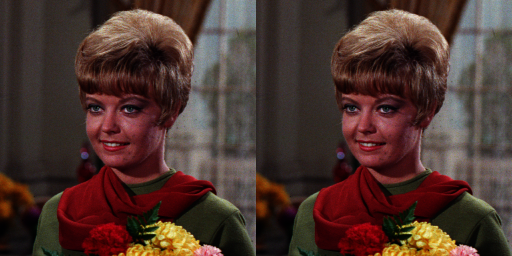

In [550]:
def dvs(arr_in : np.ndarray, voltage):
    return displayed_image(compute_pixel_current(arr_in), voltage)[1]

#transformations = {}
transformations['dvs'] = (dvs, [10, 11, 12, 13, 15], compute_panel_power)

dvs_array = dvs(sample_array, 15)
concat_horizontal(sample_image, array_to_image(dvs_array))

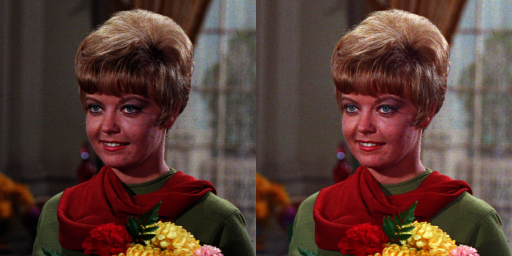

In [551]:
def brightness_dvs(arr_in : np.ndarray, voltage, brightness):
    image_array_hsv = rgb2hsv(arr_in/255)
    image_array_hsv[:, :, 2] += brightness
    arr_conv = hsv2rgb(image_array_hsv)*255

    return displayed_image(compute_pixel_current(arr_conv), voltage)[1]

#transformations['dvs'] = (dimm_saturation, [3, 6, 9, 12, 15], compute_panel_power)

brightness_dvs_array = brightness_dvs(sample_array, 15, .1)
concat_horizontal(sample_image, array_to_image(brightness_dvs_array))

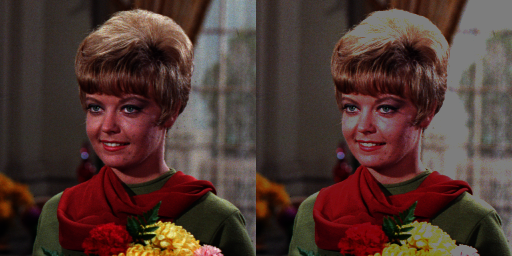

In [552]:
def contrast_dvs(arr_in : np.ndarray, voltage, brightness):
    image_array_hsv = rgb2hsv(arr_in/255)
    image_array_hsv[:, :, 2] *= brightness
    arr_conv = hsv2rgb(image_array_hsv)*255

    return displayed_image(compute_pixel_current(arr_conv), voltage)[1]

#transformations['dvs'] = (dimm_saturation, [3, 6, 9, 12, 15], compute_panel_power)

contrast_dvs_array = contrast_dvs(sample_array, 11, 1.2)
concat_horizontal(sample_image, array_to_image(contrast_dvs_array))

# Data Manipulation

In [553]:
def get_metrics(dataset, function, parameters, power_func = compute_power):
    powers = []
    distortions = []

    for image in dataset:
        distorted_image = function(image, parameters) if not parameters is None else function(image)

        power_saved = compute_power_saved(image, distorted_image, power_func)
        powers.append(power_saved)

        distortion = compute_percentage_distortion(image, distorted_image)
        distortions.append(distortion)

    return sum(powers)/len(powers), max(powers), min(powers), sum(distortions)/len(distortions), max(distortions), min(distortions)

In [554]:
datasets = {
    'Dataset 1' : [image_to_array(Image.open('dataset/1/' + path)) for path in os.listdir('dataset/1/')],
    #'Dataset 2' : [image_to_array(Image.open('dataset/2/' + path)) for path in os.listdir('dataset/2/')],
    #'Dataset 3' : [image_to_array(Image.open('dataset/3/' + path).convert('RGB)) for path in os.listdir('dataset/3/')],
}

stats = []

for dataset_name in datasets.keys():
    sdf = datasets[dataset_name]
    for name in transformations.keys():
        function, parameters, power_func = transformations[name]

        if not parameters is None:
            for parameter in parameters:
                stats.append([dataset_name, name, str(parameter), *get_metrics(sdf, function, parameter, power_func)])
        else:
            stats.append([dataset_name, name, str(parameter), *get_metrics(sdf, function, None)])

In [555]:
df_stats = pd.DataFrame(columns = ['dt_name', 'type', 'parameter', 'p_avg', 'p_min', 'p_max', 'd_avg', 'd_min', 'd_max'], data=stats)

df_stats.to_csv('metrics.csv')

print(len(df_stats), 'metrics calculated')

39 metrics calculated


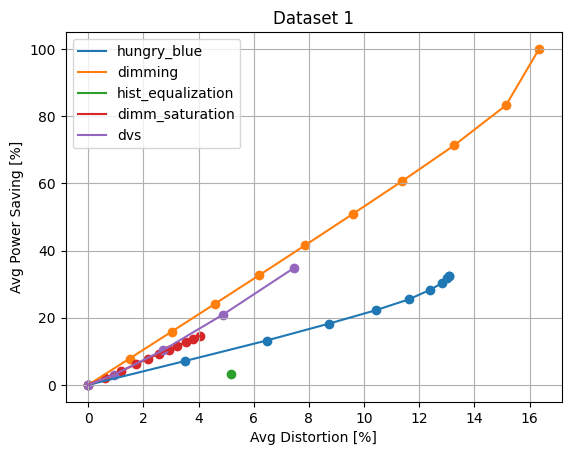

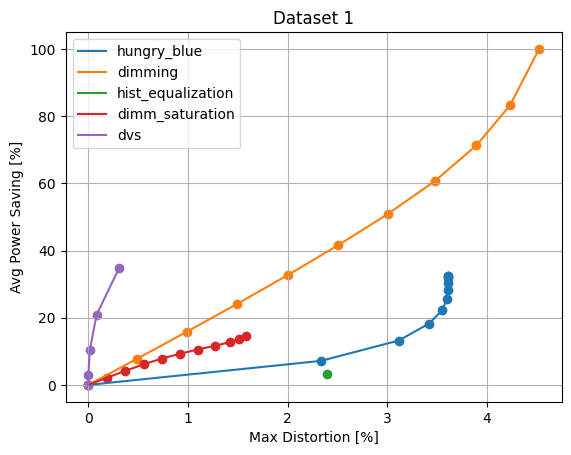

In [556]:
for dataset_name in df_stats['dt_name'].unique():
    df = df_stats[df_stats['dt_name'] == dataset_name]

    for metric_type in ['avg', 'max']:
        for tp in df['type'].unique():
            df_stats_type = df_stats[df['type'] == tp]

            plt.plot(df_stats_type[f'd_{metric_type}']*100, df_stats_type['p_avg']*100, label=tp)
            plt.scatter(df_stats_type[f'd_{metric_type}']*100, df_stats_type['p_avg']*100)

        plt.legend()
        plt.xlabel(f'{"Avg" if metric_type == "avg" else "Max"} Distortion [%]')
        plt.ylabel('Avg Power Saving [%]')
        plt.title(dataset_name)
        plt.grid()
        plt.show()